# Machine Learning and Statistics :

Introduction: Machine learning is about learning some properties of a data set and applying them to new data. 
    
It is done by dividing the dataset into Training set and Test set and is called as Cross- Validation.

Machine Learning can be done in two ways:
    
1. Supervisied Learning - There's an independent variable(1 or more) and one dependent variable on which prediction needs to be done.

a. Classification - Predict the class of unlabeled data from the labeled data. Samples belong to two or more classes.

b. Regression - The desired output consists of one or more continuous variables, then the task is called regression.

2. Unsupervised Learning - Training data consists of a set of input vectors x without any corresponding target values.

# Goal of the tutorial

The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning methods are best suited to solve it.

Given a new complaint comes in, we want to assign it to one of 12 categories. The classifier makes the assumption that each new complaint is assigned to one and only one category. This is multi-class text classification problem.

Before diving into training machine learning models, we should look at some examples first and the number of complaints in each class:

I am using the dataset used for my previous assignments (Data Cleaning and Visualization) on which I would be applying models and calculate their predictions and accuracy

In [71]:
import pandas as pd
df = pd.read_csv('/Users/sanket.DESKTOP-VJNS8K1/Downloads/Consumer_complaints.csv')
df.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,909,10/20/2015,Debt collection,Mortgage,Cont'd attempts collect debt not owed,Debt was paid,To be clear ... the is a NEW complaint against...,Company chooses not to provide a public response,WELLS FARGO & COMPANY,NY,103XX,"Older American, Servicemember",Consent provided,Web,10/20/2015,Closed with explanation,Yes,Yes,1615051
1,2289,12/01/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Taking/threatening an illegal action,Attempted to/Collected exempt funds,"Portland Credit Inc, also known as Fidelity Co...",Company believes it acted appropriately as aut...,Portland Credit Inc,OR,971XX,Servicemember,Consent provided,Web,12/01/2015,Closed with explanation,Yes,Yes,1676989
2,3404,03/21/2017,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,I went on line to XXXX XX/XX/2017 to check my ...,Company believes it acted appropriately as aut...,"Stellar Recovery, Inc.",WA,981XX,Older American,Consent provided,Web,03/21/2017,Closed with explanation,Yes,No,2394743
3,8149,03/01/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt resulted from identity theft,I was called on my cell phone by First Nationa...,Company believes it acted appropriately as aut...,"First National Collection Bureau, Inc.",CA,921XX,Servicemember,Consent provided,Web,03/01/2016,Closed with explanation,Yes,No,1809977
4,12745,06/01/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XX/XX/2015 I received a notice from ERC collec...,Company believes it acted appropriately as aut...,ERC,GA,301XX,Older American,Consent provided,Web,06/01/2016,Closed with non-monetary relief,Yes,No,1948014


For this project, we need only two columns — “Product” and “Consumer complaint narrative”.

We will remove missing values in “Consumer complaints narrative” column, and add a column encoding the product as an integer because categorical variables are often better represented by integers than strings.

We also create a couple of dictionaries for future use.

In [74]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,To be clear ... the is a NEW complaint against...,0
1,Debt collection,"Portland Credit Inc, also known as Fidelity Co...",0
2,Debt collection,I went on line to XXXX XX/XX/2017 to check my ...,0
3,Debt collection,I was called on my cell phone by First Nationa...,0
4,Debt collection,XX/XX/2015 I received a notice from ERC collec...,0


After cleaning up, this is the first five rows of the data we will be working on:

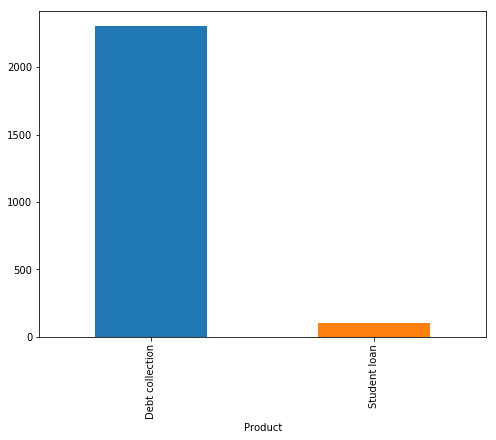

In [82]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

1. The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. 
2. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence of words is taken into consideration, but the order in which they occur is ignored.

1. Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. 
2. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:
3. sublinear_df is set to True to use a logarithmic form for frequency.
4. min_df is the minimum numbers of documents a word must be present in to be kept.
5. norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
6. ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
7. stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(2409, 6262)

Now, each of 2409 consumer complaint narratives is represented by 6262 features, representing the tf-idf score for different unigrams and bigrams.

1. To train supervised classifiers, we first transformed the “Consumer complaint narrative” into a vector of numbers. 
2. We explored vector representations such as TF-IDF weighted vectors.
3. After having this vector representations of the text we can train supervised classifiers to train unseen “Consumer complaint narrative” and predict the “product” on which they fall.

# Naive Bayes Classifier

The one most suitable for word counts is the multinomial variant

In [ ]:
#From Sklearn, sub-library model_selection, import the train_test_split to split to training and test sets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

After fitting the training set, let’s make some predictions.

In [78]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


# Model Selection

1. We can now experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

2. We will benchmark the following four models:

3. Logistic Regression
4. (Multinomial) Naive Bayes
5. Linear Support Vector Machine
6. Random Forest

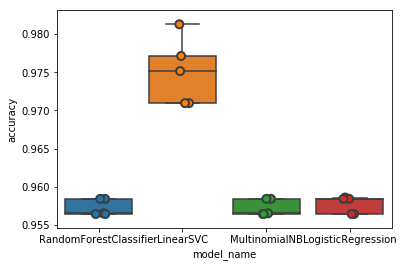

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [81]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.975097
LogisticRegression        0.957659
MultinomialNB             0.957245
RandomForestClassifier    0.957245
Name: accuracy, dtype: float64

# Conclusion :

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 97%.

# References 

scikit-learn.org/stable/tutorial/basic/tutorial.html#machine-learning-the-problem-setting

http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html

https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python